# Integer Knapsack Analysis 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from problems import IntegerKnapsack
from fastqaoa.utils import styling
from circuit_lengths import add_lengths_to_df, get_M_qpe
from regressor import fit_multi
styling.set_my_style()

## Data Loading and cleanup

In [2]:
df = pd.read_feather("../results/int_main2.feather").query("qaoa == 'quad_penalty_full_problem'")
df = pd.concat([pd.read_feather("../results/int_main4.feather"), df]).reset_index()

df["method"] = df.qaoa + "_" + df.cost
replacer = {"masked_cost_default": "IF-QAOA", "quad_penalty_cost_masked_cost": "Virtual Penalty", "quad_penalty_full_problem_masked_cost": "Slack Penalty"}
clean_names = {"depth": "QAOA Layer $p$", "rnd_approx_ratio": "RAAR", "tts": "TTS$_p$ [CLOPS]", "p_opt": r"$p_\text{opt}$", "repeats": "Repeats", "p_999": r"$p_{99.9\%}$", "p_99": r"$p_{99\%}$", "p_9": r"$p_{90\%}$", "n_qubits": "Problem Size $N$", "feas_ratio": "Feasibility Ratio"}
df["Method"] = df.method.replace(replacer)

df = df[np.logical_not(np.isnan(df.n_qubits))]
# df = df[np.logical_or(df.cost == "masked_cost", df.qaoa == "masked_cost")]

df["depth"] = df.depth.astype(int)
df["problem_id"] = df.problem_id.astype(int)

# only keep complete problem sizes in data frame
filter_df = df.groupby(["method", "n_qubits", "depth"]).problem_id.count()
ilocs = np.where(filter_df < 128)[0]
for (method, n_qubits, depth), _ in filter_df.iloc[ilocs].items():
    idx = df[(df.method == method) & (df.n_qubits == n_qubits) & (df.depth == depth)].index
    df = df.drop(idx)
    
df.head()

,index,depth,energy,approx_ratio,feas_ratio,feas_approx_ratio,p_opt,p_999,p_99,p_9,...,initial,beta_scale,gamma_scale,penalty,set_penalty,p_succ,ancilla,shift,method,Method
0,0,1,-19.786619,0.232784,0.357570,0.651016,0.059694,0.059694,0.059694,0.119797,...,constant,0.1,0.1,None,NaN,NaN,NaN,NaN,masked_cost_default,IF-QAOA
1,1,2,-35.038013,0.412212,0.553211,0.745126,0.138054,0.138054,0.138054,0.273955,...,constant,0.1,0.1,None,NaN,NaN,NaN,NaN,masked_cost_default,IF-QAOA
2,2,3,-52.203761,0.614162,0.735905,0.834567,0.247257,0.247257,0.247257,0.484680,...,constant,0.1,0.1,None,NaN,NaN,NaN,NaN,masked_cost_default,IF-QAOA
3,3,4,-66.249422,0.779405,0.886719,0.878976,0.341766,0.341766,0.341766,0.662595,...,constant,0.1,0.1,None,NaN,NaN,NaN,NaN,masked_cost_default,IF-QAOA
4,4,6,-79.716505,0.937841,0.985981,0.951176,0.460424,0.460424,0.460424,0.878795,...,constant,0.1,0.1,None,NaN,NaN,NaN,NaN,masked_cost_default,IF-QAOA


## Plotting of RAAR

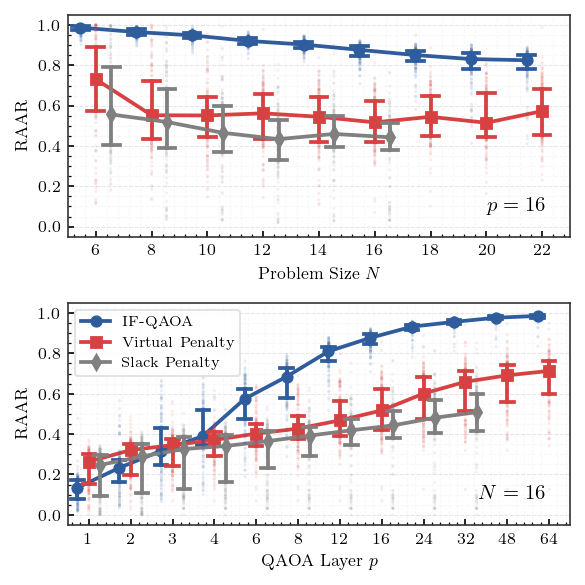

In [3]:
metric = "rnd_approx_ratio"
size = 16

fig, ax = styling.subplots(2, 1, figsize=(4, 4))
sns.pointplot(df.query("depth == @size"), x="n_qubits", y=metric, hue="Method", dodge=.55, legend=False, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"], ax=ax[0])
sns.stripplot(df.query("depth == @size"), x="n_qubits", y=metric, hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5, ax=ax[0])

ax[0].set_xlabel("Problem Size $N$")
ax[0].set_ylabel(clean_names[metric])



sns.pointplot(df.query("n_qubits == @size"), x="depth", y=metric, hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
p = sns.stripplot(df.query("n_qubits == @size"), x="depth", y=metric, hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)
sns.move_legend(p, loc="upper left", title="")


ax[1].set_xlabel("QAOA Layer $p$")
ax[1].set_ylabel(clean_names[metric])

if metric.startswith("p") or metric in ["tts"]:
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")

ax[0].text(x=0.95, y=0.1, s=f"$p = {size}$", transform=ax[0].transAxes, ha="right", va="bottom")
ax[1].text(x=0.95, y=0.1, s=f"$N = {size}$", transform=ax[1].transAxes, ha="right", va="bottom")

plt.tight_layout()

fig.subplots_adjust(hspace=0.3)

plt.savefig(f"plots/scan_{metric}_{size}.pdf")

## $P^*$ Plots

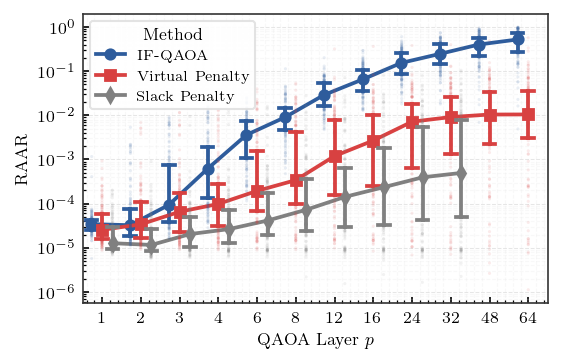

In [4]:
fig, _ = styling.subplots()
sns.pointplot(df.query("n_qubits == 16"), x="depth", y="p_opt", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("n_qubits == 16"), x="depth", y="p_opt", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel("QAOA Layer $p$")
plt.ylabel("RAAR")
plt.yscale("log")

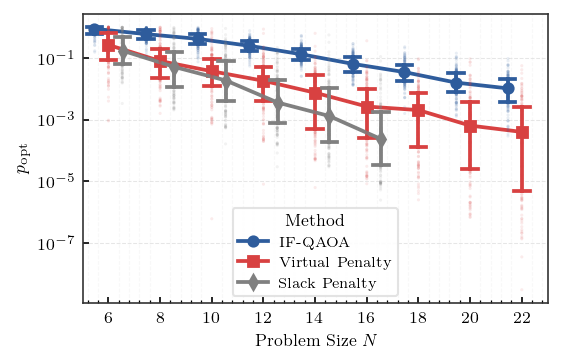

In [5]:
fig, ax = styling.subplots()
sns.pointplot(df.query("depth == 16"), x="n_qubits", y="p_opt", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("depth == 16"), x="n_qubits", y="p_opt", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel(clean_names[ax.get_xlabel()])
plt.ylabel(clean_names[ax.get_ylabel()])
plt.yscale("log")

## TTS Analysis

In [6]:
# add circuit length info for Knapsack isntances
add_lengths_to_df(df, IntegerKnapsack)

In [7]:
# compute tts in CLOPS
df["repeats"] = np.ceil(np.log(0.01) / np.log(1 - df.p_opt))
df["tts"] = df.clops * df.repeats
df["log_tts"] = np.log10(df.tts)
# fit exponentials
df_fit = fit_multi(df, x="n_qubits", y="log_tts", groupby=["method", "depth"])

# compute optimal TTS
df_opt = df.groupby(["problem_id", "method", "n_qubits"], group_keys=False).apply(lambda x: x.iloc[x.tts.argmin()], include_groups=False).reset_index()
# fit exponentials
df_opt_fit = fit_multi(df_opt, x="n_qubits", y="log_tts", groupby=["method"])
# fit power-law
df_opt["n_qubits_log"] = np.log10(df_opt.n_qubits)
df_opt_fit2 = fit_multi(df_opt, x="n_qubits_log", y="log_tts", groupby=["method"])

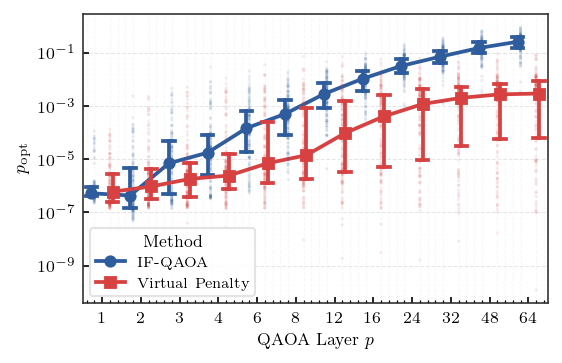

In [8]:
fig, ax = styling.subplots()
sns.pointplot(df.query("n_qubits == 22"), x="depth", y="p_opt", hue="Method", dodge=.55, legend=True, estimator=np.median, capsize=0.3, errorbar=("pi", 50), markers=["o", "s", "d"])
sns.stripplot(df.query("n_qubits == 22"), x="depth", y="p_opt", hue="Method", dodge=True, alpha=0.1, legend=False, marker='o', jitter=False, s=1.5)

plt.xlabel(clean_names[ax.get_xlabel()])
plt.ylabel(clean_names[ax.get_ylabel()])
plt.yscale("log")

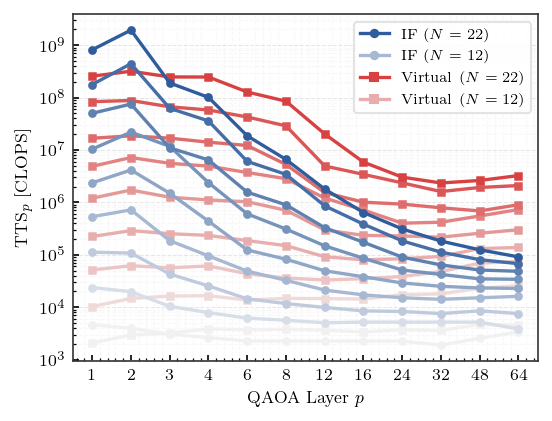

In [9]:
# Main plot with media TTS
_, ax = styling.subplots(figsize=(4, 3))

q = 0.5
style = {"markersize": 3, "linewidth": 1.6}
p = styling.shades(9, 1)
sns.pointplot(df.query("qaoa == 'quad_penalty_cost'"), x="depth", y="tts", hue="n_qubits", palette=p, legend=True, marker="s", estimator=lambda x: np.quantile(x, q), errorbar=None, **style)
b = p

p = styling.shades(9, 0)
tgt = sns.pointplot(df.query("qaoa == 'masked_cost'"), x="depth", y="tts", hue="n_qubits", palette=p, marker="o", estimator=lambda x: np.quantile(x, q), errorbar=None, **style)

plt.yscale("log")
plt.ylabel(clean_names[ax.get_ylabel()])

plt.xlabel(clean_names[ax.get_xlabel()])

x, y = ax.get_legend_handles_labels()
ax.legend_.remove()


legend_elements = [
    # Blue gradient (IF-QAOA)
    Line2D([0], [0], color=p[-1], lw=1.6, marker='o', label='IF ($N=22$)'),
    # Line2D([0], [0], color=p[len(p) //2], lw=2, marker='o', label=''),
    Line2D([0], [0], color=p[3], lw=1.6, marker='o', label='IF ($N=12$)'),
    
    # Red gradient (Virtual Penalty)
    Line2D([0], [0], color=b[-1], lw=1.6, marker='s', label='Virtual ($N=22$)'),
    # Line2D([0], [0], color=b[len(p) //2], lw=2, marker='s', label=''),
    Line2D([0], [0], color=b[3], lw=1.6, marker='s', label='Virtual ($N=12$)')
]

plt.legend(handles=legend_elements, loc="upper right")


plt.savefig("plots/int_clops.pdf", bbox_inches="tight", transparent=True)

slope        0.112656
intercept    2.643891
rvalue       0.744781
lower        0.108840
upper        0.116471
Name: masked_cost_default, dtype: float64
slope        0.211525
intercept    2.041383
rvalue       0.658187
lower        0.202706
upper        0.220344
Name: quad_penalty_cost_masked_cost, dtype: float64
slope        0.294387
intercept    1.511066
rvalue       0.718323
lower        0.281312
upper        0.307463
Name: quad_penalty_full_problem_masked_cost, dtype: float64


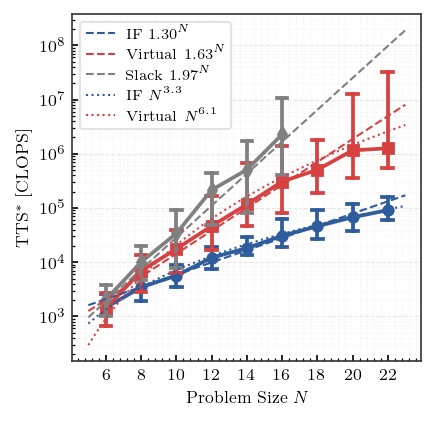

In [10]:
styling.subplots(figsize=(3, 3))
# sns.stripplot(df_opt, x="n_qubits", y="tts", hue="method", dodge=0.3, legend=False, alpha=0.1)#, errorbar=("pi",50), estimator=np.median)
sns.pointplot(df_opt, x="n_qubits", y="tts", hue="Method", errorbar=("pi", 50), estimator=np.median, capsize=0.3, markers=["o", "s", "d"], legend=False)

replacer_short = {"masked_cost_default": "IF", "quad_penalty_cost_masked_cost": "Virtual", "quad_penalty_full_problem_masked_cost": "Slack"}

def plot_fit(d):
    print(d)
    x  = np.linspace(5, 23, 100)
    y = 10 ** d.slope 
    plt.plot((x - 6) / 2,  10 ** (d.intercept + d.slope * x), linestyle="--", label=f"{replacer_short[d.name]} {y:.2f}$^N$")

df_opt_fit.apply(plot_fit, axis=1)
df_opt_fit["scale"] = 10 ** df_opt_fit.slope

cmap = {"masked_cost_default": styling.COLORS[0], "quad_penalty_cost_masked_cost": styling.COLORS[1]}

def plot_fit2(d):
    if d.name == "quad_penalty_full_problem_masked_cost":
        return
    x  = np.linspace(5, 23, 100)
    # y = 10 ** d.slope 
    plt.plot((x - 6) / 2,  np.pow(x, d.slope) * 10 ** (d.intercept), linestyle=":", label=f"{replacer_short[d.name]} " + "$N^{" + f"{d.slope:.1f}" + "}$", color=cmap[d.name])

df_opt_fit2.apply(plot_fit2, axis=1)


plt.yscale("log")

plt.xlabel("Problem Size $N$")
plt.ylabel(r"TTS$^*$ [CLOPS]")
plt.legend()
plt.savefig("plots/scaling_tts_opt.pdf")

### Additional Plots

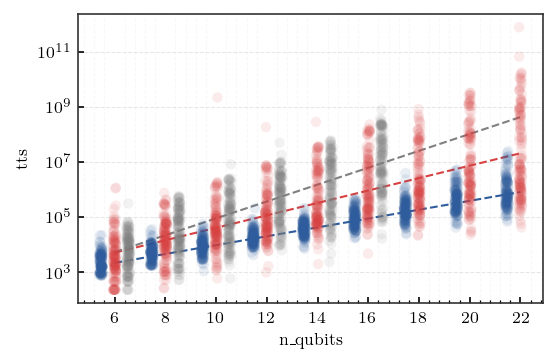

In [11]:
# qp.plot_setup()
d = 16

styling.subplots()

sns.stripplot(df.query("depth==@d"), x="n_qubits", y="tts", hue="method", dodge=0.3, legend=False, alpha=0.1)#, errorbar=("pi",50), estimator=np.median)
# sns.pointplot(df.query("depth==@d"), x="n_qubits", y="tts", hue="method", dodge=0.3, legend=False, errorbar=("pi",50), estimator=np.median)
# x = np.arange(6, 24, 2)
# plt.plot(x, (0.2829 + 0.005) * x + 1.04)

# plt.yscale("log")



x = np.linspace(6, 22, 100)
xi = np.linspace(0, (22 - 6) / 2, 100)
def plot_fit(d):
    plt.plot(xi,  10 ** (d.intercept + d.slope * x), linestyle="--")

df_fit.query("depth == @d").apply(plot_fit, axis=1)
plt.yscale("log")

/var/folders/0y/wbcxhvy92xz19jsf8x4s17km0000gn/T/ipykernel_68732/1636818636.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfx.groupby("method").apply(plot_method)


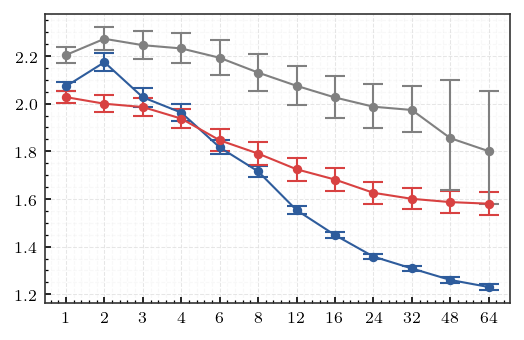

In [12]:
# fitted exponential base in relation to QAOA depth

styling.subplots()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(10 ** (x[["lower", "upper"]].to_numpy().T) - 10 ** (x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), 10 ** x.slope, yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

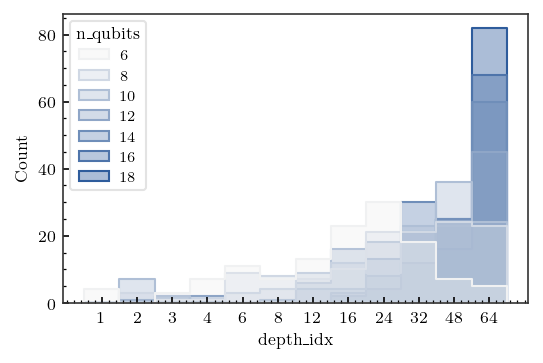

In [13]:
# opt p value histogram
_, ax = styling.subplots()

depth_to_idx = list(sorted(df.depth.unique()))

df_opt["depth_idx"] = df_opt.depth.apply(lambda x: depth_to_idx.index(x))

palette = styling.shades(7)
sns.histplot(df_opt.query("method == 'masked_cost_default' and n_qubits < 20"), x="depth_idx", bins=np.arange(0, len(depth_to_idx) + 1 ), hue="n_qubits", alpha=0.4, element="step", palette=palette)
## sns.kdeplot(df_opt.query("method == '' and n_qubits < 20"), x="depth_idx", hue="n_qubits", palette=palette, )
ax.grid(False, which="minor")
ax.grid(False)

ax.set_xticks(np.arange(len(depth_to_idx)) + 0.5, depth_to_idx)
np.arange(0, len(depth_to_idx) + 1 )

## Correlation Plots

In [14]:
def corrplot(figsize=(3, 3)):
    fig, ax = styling.subplots(figsize=figsize)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot([100, 10 ** 9], [100, 10 ** 9], color="k")
    ax.set_xlim(100, 10 ** 9)
    ax.set_ylim(100, 10 ** 9)
    return fig, ax

dfx = df_opt.query("method in ['masked_cost_default', 'quad_penalty_cost_masked_cost']")
dfx = dfx.pivot(columns="method", index=["n_qubits", "problem_id"], values="tts").reset_index()


instances = IntegerKnapsack.get_instances()

def f(x):
    instance = instances[int(x.n_qubits)][int(x.problem_id)]
    return np.corrcoef(instance.weights, instance.costs)[0, 1]

dfx["corr"] = dfx.apply(f, axis=1)

def f(x):
    instance = instances[int(x.n_qubits)][int(x.problem_id)]
    return instance.max_capacity / sum(instance.weights)

dfx["weight_ratio"] = dfx.apply(f, axis=1)


print(np.mean(dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost))
print(np.mean(2 * dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost))
print(np.mean(100 * dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost))

0.8211805555555556
0.6927083333333334
0.10416666666666667


<Axes: xlabel='masked_cost_default', ylabel='quad_penalty_cost_masked_cost'>

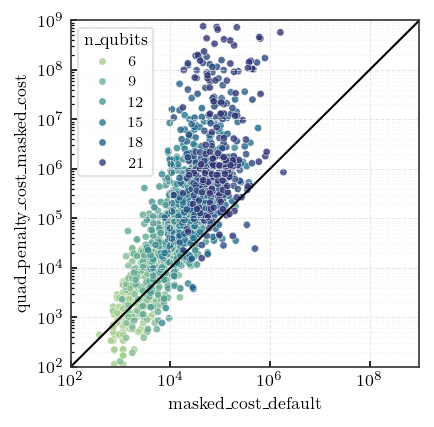

In [15]:
corrplot()

sns.scatterplot(dfx, x="masked_cost_default", y="quad_penalty_cost_masked_cost", alpha=0.8, hue="n_qubits", palette="crest")

<Axes: xlabel='masked_cost_default', ylabel='quad_penalty_cost_masked_cost'>

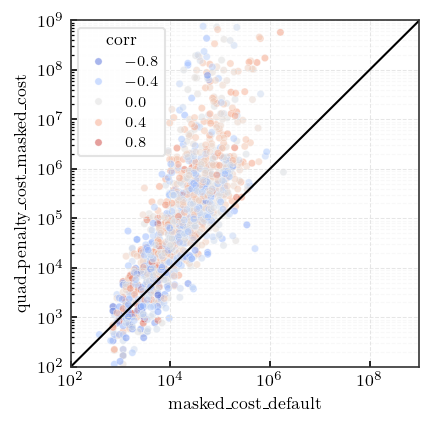

In [16]:
corrplot()

sns.scatterplot(dfx, x="masked_cost_default", y="quad_penalty_cost_masked_cost", alpha=0.5, hue="corr", palette="coolwarm")

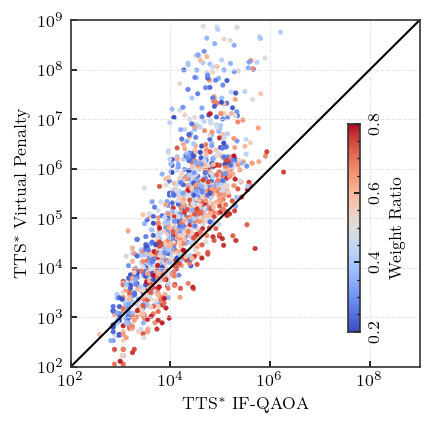

In [17]:
fig, ax = corrplot(figsize=(3, 3))

x = sns.scatterplot(dfx, x="masked_cost_default", y="quad_penalty_cost_masked_cost", alpha=1, hue="weight_ratio", palette="coolwarm", edgecolor=None, s=5, legend=False)

cax = inset_axes(ax, loc="lower right", width="4%", height="60%", bbox_to_anchor=(0, 0.08, 0.85, 1),
                      bbox_transform=ax.transAxes)

norm = plt.Normalize(0.2, 0.8)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

# Define colormap and value range
cmap = plt.cm.coolwarm
vmin, vmax = 0.2, 0.8

# Create gradient data
gradient = np.linspace(0, 1, 256).reshape(256, 1)
gradient = np.hstack((gradient, gradient))

# Turn off axis ticks and spines for clean appearance
cax.set_xticks([])
cax.yaxis.tick_right()  # Move ticks to right side
cax.grid(False)
cax.grid(False, which="minor")

# Plot the gradient image
cax.imshow(gradient, aspect='auto', cmap=cmap, 
          extent=[0, 1, vmin, vmax], origin='lower')
cax.yaxis.set_tick_params(rotation=90)
for tick in cax.get_yticklabels():
    tick.set_verticalalignment('center')
cax.set_ylabel("Weight Ratio")
cax.yaxis.set_label_position("right")

ax.minorticks_off()  # Turn off minor grid lines

ax.set_xlabel("TTS$^*$ IF-QAOA")
ax.set_ylabel("TTS$^*$ Virtual Penalty")

plt.savefig("plots/corr_tts_weight_ratio.pdf")

## Speedup

In [18]:
dfx["if_faster"] = dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost
dfx["if_10x"] = 10 * dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost
dfx["if_100x"] = 100 * dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost
# dfx["if_1000x"] = 1000 * dfx.masked_cost_default < dfx.quad_penalty_cost_masked_cost


dfy = (dfx.groupby("n_qubits")[["if_faster", "if_10x", "if_100x"]].sum() / 128).reset_index()

dfy = pd.melt(dfy, id_vars=['n_qubits'], var_name='method', value_name='value')

dfy["value100"] = dfy.value * 100

dfy["$r$"] = dfy.method.map({"if_faster": 1, "if_10x": 10, "if_100x": 100})

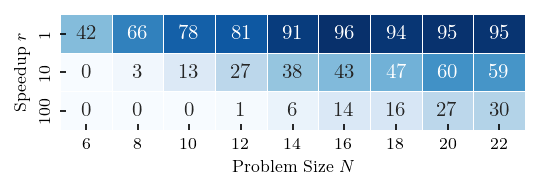

In [19]:
fig, ax = styling.subplots(figsize=(4, 1))

sns.heatmap(dfy.pivot(index="$r$", columns="n_qubits", values="value100"), annot=True, cmap="Blues", fmt=".0f", cbar=False, xticklabels=True, linewidths=0.3)
plt.xlabel("Problem Size $N$")
plt.ylabel("Speedup $r$")
plt.grid(False)
plt.grid(False, which="minor")
plt.minorticks_off()
plt.savefig("plots/speedup.pdf", bbox_inches="tight")

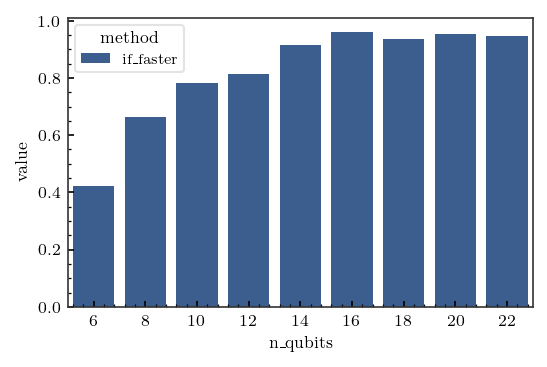

In [20]:
sns.barplot(dfy.query("method == 'if_faster'"), x="n_qubits", y="value", hue="method")
plt.grid(False)
plt.grid(False, which="minor")

In [21]:
dfz = dfy.pivot(columns="n_qubits", index="method", values="value")

print("\\begin{table}{r|" + f"{'r'*len(dfz.columns)}" + "}")
print("& " + " & ".join(map(str, dfz.columns)) + "\\\\")
print("1 &", " & ".join(map(lambda x: f"{round(100 * x)}\\%", dfz.loc["if_faster"].values)), "\\\\")
print("10 &", " & ".join(map(lambda x: f"{round(100 * x)}\\%", dfz.loc["if_10x"].values)), "\\\\")
print("100 &", " & ".join(map(lambda x: f"{round(100 * x)}\\%", dfz.loc["if_100x"].values)))
print("\\end{table}")

dfy.groupby("method").mean()

\begin{table}{r|rrrrrrrrr}
& 6 & 8 & 10 & 12 & 14 & 16 & 18 & 20 & 22\\
1 & 42\% & 66\% & 78\% & 81\% & 91\% & 96\% & 94\% & 95\% & 95\% \\
10 & 0\% & 3\% & 13\% & 27\% & 38\% & 43\% & 47\% & 60\% & 59\% \\
100 & 0\% & 0\% & 0\% & 1\% & 6\% & 14\% & 16\% & 27\% & 30\%
\end{table}


,n_qubits,value,value100,$r$
method,,,,
if_100x,14.0,0.104167,10.416667,100.0
if_10x,14.0,0.322917,32.291667,10.0
if_faster,14.0,0.821181,82.118056,1.0


In [22]:
dfx2 = df.query("depth==16").pivot(columns="Method", index=("n_qubits", "problem_id"), values="approx_ratio")

print("AR", np.mean(dfx2['IF-QAOA'] / dfx2["Virtual Penalty"] - 1))

dfx3 = 1 - dfx2

print("", np.median(dfx3['IF-QAOA'] / dfx3["Virtual Penalty"]))
dfx3['IF-QAOA'] / dfx3["Virtual Penalty"]

AR 0.416423766398142
 0.22972137905347886


n_qubits  problem_id
6         0              0.033551
          1             30.388917
          2              0.103875
          3              0.084681
          4              0.035812
                          ...    
22        123            1.174656
          124            0.843022
          125            0.440342
          126            0.595058
          127            0.305718
Length: 1152, dtype: float64

<Axes: xlabel='n_qubits', ylabel='rnd_approx_ratio'>

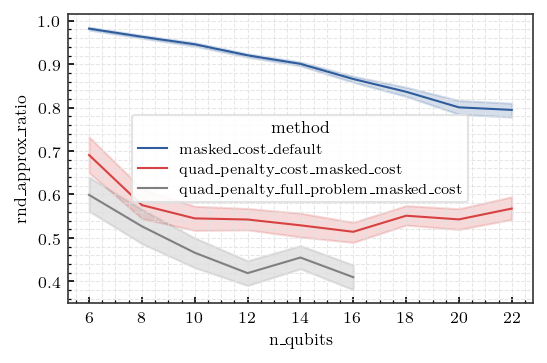

In [23]:
sns.lineplot(df.query("depth == 16"), x="n_qubits", y="rnd_approx_ratio", hue="method")